# Deep Learning Model 

In [10]:
#!pip3 install opencv-python
!pip install tensorflow
!pip install sklearn
!pip install seaborn
!pip install matplotlib

     |████████████████████████████████| 217.5 MB 14.7 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 551 kB/s eta 0:00:01
     |████████████████████████████████| 962 kB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 818 kB/s eta 0:00:01
     |████████████████████████████████| 42 kB 4.5 MB/s  eta 0:00:01
     |████████████████████████████████| 13.2 MB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 17.2 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████|

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=6d63900b26b04695f4d8c1c4254f15047450a8a7631a2ddf83f392135e2084d6
  Stored in directory: /Users/cynthiaurgel/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [1]:
# Libraries

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import random
import pickle


#from PIL import Image
#!pip install mat73
import mat73
import helper

#import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt


### Parameters

In [2]:
resize = 0.2

## Image loading and preprocessing

In [3]:
### Load each file independently (to avoid memory overflows) and retriev PID
patient_ids_dict = dict()
label_ids_dict = dict()
shape_x_dict = dict()
shape_y_dict = dict()
image_dict = dict()

for file_number in range(1,3047):
    file = f'../data/brain-tumor-data-public/{file_number}.mat'
    data_dict = mat73.loadmat(file)
    patient_ids_dict[file_number] = data_dict['cjdata']['PID']
    label_ids_dict[file_number] = int(data_dict['cjdata']['label'])
    shape_x_dict[file_number] = data_dict['cjdata']['image'].shape[0]
    shape_y_dict[file_number] = data_dict['cjdata']['image'].shape[1]
    image_dict[file_number] = data_dict['cjdata']['image']

In [4]:
patient_ids = pd.Series(patient_ids_dict)
label_ids = pd.Series(label_ids_dict)
shape_x = pd.Series(shape_x_dict)
shape_y = pd.Series(shape_y_dict)
image = pd.Series(image_dict)

patients = pd.DataFrame({'pid':patient_ids, 'label':label_ids,
                         'x':shape_x, 'y':shape_y, 'image':image}, index=range(1, 3047))

In [5]:
patients['image'] = patients['image'].apply(lambda x : helper.imx_preproc(x, zero_up_to_one=True, resize=resize))
patients['image'] = patients['image'].apply(lambda x : x.astype('float32'))

## Train and Validation Sets

In [6]:
random.seed(1234)

val_size = 0.2
test_size = 0.2
# Training set has 2436 images test set has 610 images 
train_set, test_set = train_test_split(patients, stratify=patients['label'], test_size=test_size)
# Training set has 1948 images, validation set has 488 images
train_set, val_set = train_test_split(train_set, stratify=train_set['label'], test_size=val_size)

n_total_train = train_set.shape[0]

train_set_x = np.stack(train_set['image'].values)
train_set_y = np.array(train_set['label'])

val_set_x = np.stack(val_set['image'].values)
val_set_y = np.array(val_set['label'])

test_set_x = np.stack(test_set['image'].values)
test_set_y = np.array(test_set['label'])

Applying one hot encoding to target variable y 

In [7]:
new_train_set_y = tf.one_hot(train_set_y, depth = 4)
new_train_set_y = np.array(new_train_set_y)[:,1:]

2022-05-03 20:42:39.184667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
new_val_set_y = tf.one_hot(val_set_y, depth = 4)
new_val_set_y = np.array(new_val_set_y)[:,1:]

## CNN Implementation

In [9]:
batch_size = 64
IMG_H = int(round(512 * resize, 0))
IMG_W = int(round(512 * resize, 0))

In [10]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 1)),
    
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')
    Dense(3, activation='softmax')
])

CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0

In [11]:
optimizer = 'adam'

In [12]:
# Compile: Define training parameters
CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train model
EPOCHS = 10
BATCHES = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, new_train_set_y, steps_per_epoch=BATCHES,
                       epochs=EPOCHS, validation_data=(val_set_x, new_val_set_y))

Epoch 1/10
30/30 [==============================] - 16s 509ms/step - loss: 0.8499 - accuracy: 0.6027 - val_loss: 0.6619 - val_accuracy: 0.6721
Epoch 2/10
30/30 [==============================] - 15s 487ms/step - loss: 0.6309 - accuracy: 0.7089 - val_loss: 0.6697 - val_accuracy: 0.6680
Epoch 3/10
30/30 [==============================] - 15s 489ms/step - loss: 0.5394 - accuracy: 0.7675 - val_loss: 0.4514 - val_accuracy: 0.7828
Epoch 4/10
30/30 [==============================] - 14s 482ms/step - loss: 0.4786 - accuracy: 0.7864 - val_loss: 0.4294 - val_accuracy: 0.8176
Epoch 5/10
30/30 [==============================] - 15s 484ms/step - loss: 0.3818 - accuracy: 0.8352 - val_loss: 0.3418 - val_accuracy: 0.8586
Epoch 6/10
30/30 [==============================] - 14s 479ms/step - loss: 0.3101 - accuracy: 0.8727 - val_loss: 0.3367 - val_accuracy: 0.8586
Epoch 7/10
30/30 [==============================] - 15s 494ms/step - loss: 0.2180 - accuracy: 0.9081 - val_loss: 0.2753 - val_accuracy: 0.8996

### Results

In [14]:
model_id = 'cupl_1'

#### Summary

In [26]:
with open(f'../results/resize_{resize}/{model_id}_summary.txt', 'w') as f:

    CNN.summary(print_fn=lambda x: f.write(x + '\n'))
    f.close()

#### Hyperparameters

In [27]:
with open(f"../results/resize_{resize}/{model_id}_extended_summary.txt","w") as f:
    aux = CNN.get_config()
    aux['optimizer'] = optimizer
    aux['epoch'] = EPOCHS
    aux['batches'] = BATCHES
    f.write(str(aux))
    f.close()

#### Epoch convergence

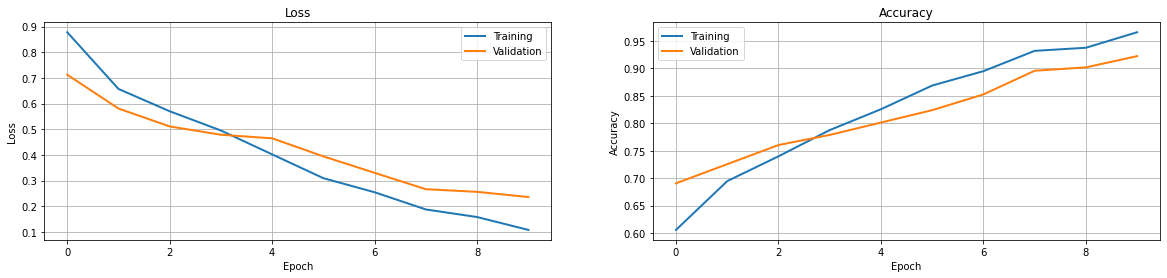

In [28]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(CNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(CNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.savefig(f'../results/resize_{resize}/{model_id}_epochs.png', bbox_inches = 'tight')
plt.show()

#### Confusion Matrix

In [15]:
predictions = CNN.predict(test_set_x)  #por qué no se hace el OHE?
predictions = predictions.argmax(1) + 1

cm = confusion_matrix(test_set_y, predictions)

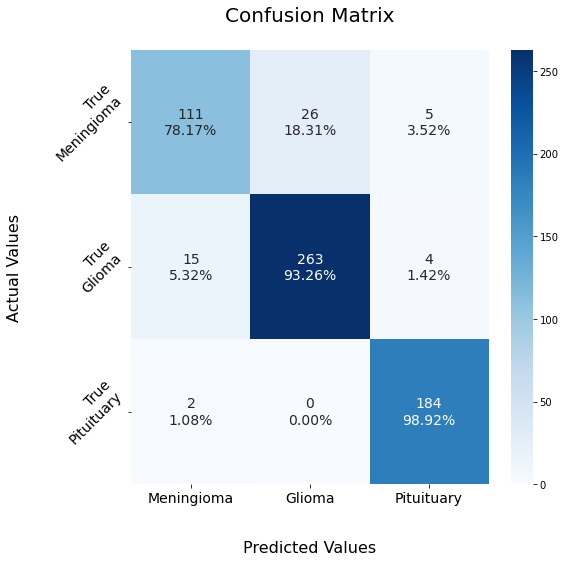

In [46]:
fig, ax = plt.subplots(figsize = (8,8))

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     ((cm.transpose()/cm.sum(1)).transpose()).flatten()]

#group_percentages = ["{0:.2%}".format(value) for value in
#                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cm,
                 annot=labels, 
                 fmt='',
                 cmap='Blues',
                 annot_kws = {'fontsize':14})

ax.set_title('Confusion Matrix\n', fontsize = 20);
ax.set_xlabel('\nPredicted Values', labelpad = 18, fontsize = 16)
ax.set_ylabel('Actual Values', labelpad = 20, fontsize = 16);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Meningioma','Glioma', 'Pituituary'], fontsize = 14)
ax.yaxis.set_ticklabels(['True\nMeningioma','True\nGlioma', 'True\nPituituary'], fontsize = 14, rotation = 45)

## Display the visualization of the Confusion Matrix.
plt.savefig(f'../results/resize_{resize}/{model_id}_confusion_matrix.png', bbox_inches = 'tight')
plt.show()

In [30]:
f1 = f1_score(test_set_y, predictions, average='weighted')
acc = accuracy_score(test_set_y, predictions)

In [34]:
with open(f'../results/resize_{resize}/{model_id}_performance.txt', 'w') as f:

    performance = {'F1 score': round(f1,4), 'Accuracy': round(acc,4)}
    
    f.write(str(performance))
    f.close()

#### Pickle file

In [30]:
CNN.save(f'../results/resize_{resize}/{model_id}_model.h5')